In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '.')
sys.path.insert(0, '..')

In [3]:
import re
import pandas as pd

***

In [242]:
recipes = pd.read_csv('../data/food_ingredients_711.csv')
recipes = recipes.loc[recipes["productname"].notnull(),]
recipes.head()

OrderableUPC                                        productname category  \
0   28498000425                                             Muffin  SNKCAKE   
1   52548634827  7-Eleven Peanut Butter & Jelly Sandwich, FG CA...      NaN   
2   46704068403                                       Potato Skins  FRZNSNK   
3  471101721253  7-Eleven Bavarian Chocolate Iced Long John, IL...      NaN   
5   25600088944                                             Donuts  SNKCAKE   

           brand                                        ingredients  
0  BROWNIE BAKER  Sugar, Enriched Bleached Flour (Wheat Flour, F...  
1            NaN  WHITE BREAD (All PURPOSE FLOUR (WHEAT FLOUR EN...  
2    TGI FRIDAYS  Potato Skins (Potatoes, Water, Batter Mix, (Mo...  
3            NaN  DONUT DOUGH (DONUT MIX (ENRICHED WHEAT FLOUR B...  
5      TASTYKAKE  Enriched Unbleached and Bleached Flour (Wheat ...

In [245]:
list(recipes.loc[recipes["category"].notnull(), "category"].unique())

['SNKCAKE',
 'FRZNSNK',
 'FRZNMEAL',
 'BREAD',
 'COOKIE',
 'FRZNPZZA',
 'DELI',
 'MEXICAN',
 '7ELEVEN',
 'MARSSNCK',
 'FRZNBRK',
 'FRZNBAKE',
 'JUICE',
 'FRZNVEG',
 'SOUP',
 'PICKLES',
 'PRODUCE',
 'DAIRY',
 'CRACKERS',
 'DESSERT',
 'SNACKS',
 'CEREAL',
 'ICECREAM',
 'CANDY',
 'FRZNFISH']

In [89]:
labels = list(recipes["productname"].values)
raw_texts = list(recipes["ingredients"].values)

# Clean up the ingredients

In [90]:
def ingredient_cleanup(raw_texts, topn=100):
    from collections import Counter
    texts = []
    for text in raw_texts:
        tmp = re.sub("[\(\[].*?[\)\]]", "", text) \
        .replace(", ", ",") \
        .replace(",  ", ",") \
        .replace("  ,", ",") \
        .replace(" ,", ",") \
        .replace(" , ", ",") \
        .lower()
        texts.append(re.sub('[^a-zA-Z ,]+', '', tmp))
    vocab_ = [i for text in texts for i in text.split(',')]
    c = Counter(vocab_).most_common(topn)
    vocab = [i[0] for i in c]
    return texts, vocab

In [91]:
texts, vocab = ingredient_cleanup(raw_texts)

In [93]:
vocab[:10]

['salt',
 'water',
 'sugar',
 'soy lecithin',
 'soybean oil',
 'dextrose',
 'yeast',
 'enzymes',
 'xanthan gum',
 'leavening']

In [99]:
vocab_aug[:10]

['salt',
 'sugar',
 'water',
 'citric acid',
 'corn syrup',
 '',
 'soy lecithin',
 'natural flavor',
 'natural flavors',
 'dextrose']

***

In [94]:
recipes_aug = pd.read_csv("../data/food_ingredients_augment.csv")
recipes_aug = recipes_aug.loc[recipes_aug["features_value"].notnull(),]

In [96]:
texts_raw_aug = list(recipes_aug["features_value"].values)
labels_aug = list(recipes_aug["name"].values)

In [97]:
texts_aug, vocab_aug = ingredient_cleanup(texts_raw_aug)

In [100]:
labels_aug

['Simon Fischer Fruit Bttr Prune Lekvar',
 'McCORMICK GRILL MATES MOLASSES BACON SEASONING 1 x 77g JAR AMERICAN IMPORT',
 'Jolly Time Popcorn',
 'Ziyad Tahini Sesame Sauce',
 'Fla-Vor-Ice Plus Giant Pops',
 'Hero Fruit Sprd Blk Currant-12 Oz -pack of 8',
 'Simply Asia Noodle Bowl Mandarin Orange -- 8.5 oz',
 'Italian Bread Crumbs',
 'BACK TO NATURE CEREAL ORANGE CRUNCH GRAN',
 'Nutrament Strawberry Complete Nutrition Drink 12 Fl. Oz. Can',
 'Kikkoman Original Pearl Organic Soymilk, 32oz',
 'Kikkoman Chocolate Pearl Organic Soymilk, 32 Fl Oz',
 'Blue Diamond Almondsï¿½ï¿½ Almond Breezeï¿½ï¿½ Chocolate Almondmilk 0.5 Gal. Carton',
 "Stella D'oro Roasted Garlic Breadsticks, 7.8 Oz",
 'Badia Anise Seed, .5 Oz',
 "Tone's Garlic Powder, 2.88 Oz",
 'Trolli Sour Brite Eggs, 4.0 Ounce Bags, (pack of 12)',
 'Cornnuts Ranch Bag',
 'Planters Pistachio Lovers Mix 18.5 Oz. Canister',
 'Bob Evansï¿½ï¿½ Tasteful Sidesï¿½ï¿½ï¿½ Macaroni & Cheese 28 Oz. Tray',
 'Ground Cumin',
 "Nature's Path Organic Lo

# Clean up the labels (food names)

- Use Gensim Doc2Vec to convert food names to vectors
- Use Kmeans to cluster them
- Use those cluster labels for food classification

In [103]:
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [161]:
recipes = pd.read_csv('../data/food_ingredients_711.csv')
recipes = recipes.loc[recipes["productname"].notnull(),]
labels_711 = list(recipes["productname"].values)

## Train sentence embedding

In [219]:
def read_corpus(labels, tokens_only=False):
    for i, line in enumerate(labels):
        line_ = line.replace("7-Eleven ", "")
        line_ = re.sub('[^a-zA-Z ,]+', '', str(line_))  # removing numbers, symbols, etc.
        tokens = gensim.utils.simple_preprocess(line_)  # removing 7-Eleven from food name
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [220]:
corpus = list(read_corpus(labels_711))

In [221]:
corpus[:2]

[TaggedDocument(words=['muffin'], tags=[0]),
 TaggedDocument(words=['peanut', 'butter', 'jelly', 'sandwich', 'fg', 'ca'], tags=[1])]

In [222]:
# training the model
d2v_model = gensim.models.doc2vec.Doc2Vec(vector_size=10, min_count=2, epochs=20)
d2v_model.build_vocab(corpus)

In [223]:
d2v_model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [224]:
vector = d2v_model.infer_vector(['grill', 'chicken'])
print(vector)

[-0.01178029  0.02684033 -0.09150469  0.12040245 -0.06925331  0.0445003
  0.11251073  0.03345844 -0.04383349  0.13134892]


## Cluster trained embeddings

In [234]:
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=100)
X = kmeans_model.fit(d2v_model.docvecs.vectors_docs)
labels = kmeans_model.labels_.tolist()

In [235]:
l = kmeans_model.fit_predict(d2v_model.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(d2v_model.docvecs.vectors_docs)
datapoint = pca.transform(d2v_model.docvecs.vectors_docs)

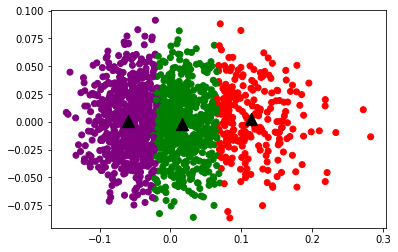

In [236]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure
label1 = ['#008000', '#800080', '#FF0000', '#00FF00', '#0000FF',]
#           '#FFFF00', '#00FFFF', '#FF00FF']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [237]:
def get_foods_in_cluster(cluster_num, cluster_labels, food_names):
    idx = [i for i, x in enumerate(cluster_labels) if x == cluster_num]
    return [food_names[i] for i in idx]

In [238]:
labels_711_ = []
for i in labels_711:
    labels_711_.append(i.replace("7-Eleven ", ""))

In [239]:
get_foods_in_cluster(0, labels, labels_711_)

['Peanut Butter & Jelly Sandwich, FG CA, 3/19',
 'Potato Skins',
 'Donuts',
 'FTG Chococlate Chip Muffin MHT, 10/18',
 'Pound Cake',
 'TM FTG Cheese Muffin, Chicago, 8/18',
 'Cranberry Chicken Salad on Croissant, 10/18',
 'Bread',
 'Crispy Wheels',
 'Chocolate Bar, AZ, 10/18',
 'Sausage, Cheddar Cheese and Jalepeno Kolache, TX, 11/18',
 'Brownie',
 'Maple Pecan Danish, TX, 11/18',
 'Lunch Combinations',
 'Nutty Bars',
 'Kandy Bar Kakes',
 'Tortillas',
 'Tortillas',
 'Donuts',
 'LM Cuban Press, FL, 3/19',
 'Bagels',
 'Nutty Buddy',
 'Chocolate Frosted Donut, AZ, 10/18',
 'Twinkies',
 'Kandy Kakes',
 'Brownies',
 'HF Jalapeno Sausage Kolache WB, TX, 3/19',
 'Butter Cake',
 'Creme Pie',
 'Patriotic Donut, MD, 10/18',
 'Ciabatta',
 'National_BnAp Galleta Con Pasas 4.25oz_0819',
 'Pandebono, FL, 10/18',
 'Turkey Havarti, TX, 9/18',
 'Cupkakes',
 'Cup Cakes',
 'Pesto Tortellini',
 'Prime Greek Pasta Salad, Dallas, 8/18',
 'NP Yoplait Strawberry Blueberry Parfait, 9/18',
 'Sandwiches',
 'Fine

In [240]:
get_foods_in_cluster(1, labels, labels_711_)

['Muffin',
 'Donuts',
 'Squares',
 "Donuts O's",
 'Mexican Casserole',
 'Bread',
 'Pie',
 'Angel Wings',
 'Bread',
 'Krimpets',
 'Cookies',
 'Flavored Pie',
 'Cake',
 'Bread',
 'Sandwiches',
 'Pizza Rolls',
 'Cookies',
 'Pie',
 'Kandy Kakes',
 'Pizza',
 'Bagels',
 'Sandwich',
 'Sandwich',
 'Cream Cheese Cake',
 'Donuts',
 'FG-SCA_Everything Bagel_0619',
 'Hamburger Buns',
 'National_BnAp Muffin Cheese 5.5oz (SLIN 170708)_0819',
 'Sweet Rolls',
 'Bread',
 'Rangoon',
 'Bread',
 'Pizza',
 'Donuts',
 'Donuts',
 'Donuts',
 'Kandy Kakes',
 'Donuts',
 'Burger',
 'Cupkakes',
 'NB_Banquet Chicken Nuggets 12oz_0220',
 'Bread',
 'Bread',
 'Chicken Salad w/ Lettuce, 10/18',
 'Mac & Cheese',
 'Bread',
 'Donuts',
 'Egg Salad w/ Lettuce, 10/18',
 'Donuts',
 'Bulkie Rolls',
 'Bread',
 'Donuts',
 'NB_Bimbo Nito 4.38oz 2 Pack_0220',
 'Oatmeal Raisin Cookie 2pk, 10/18',
 'Cookies',
 'Bread',
 'Tortillas',
 'Bread',
 'Krimpets',
 'Totally Nutty',
 'Twinkies',
 'Bread',
 'Hamburger Buns',
 'Buns',
 'Donuts

In [241]:
get_foods_in_cluster(2, labels, labels_711_)

['Bavarian Chocolate Iced Long John, IL, 10/18',
 'Italian 6in Value Sub AP, VA, 10/18',
 'Tyson Chicken Wing - Spicy (5 piece)',
 'Bistro Ham & Swiss on Pretzel Roll AP, 10/18',
 'Smoked Chicken Salad Sandwich, WA, 4/19',
 'Saginaw Sugar Cookie Made w/ M&M Chocolate Candy 2pk, BC, 9/18',
 'Custard Filled Long John, MI, 10/18',
 'Jumbo Black & White Cookie, NY, 3/19',
 'Prime Chicken Caesar Salad with Dressing, Dallas, 8/18',
 'FTG NP Balsamic Garden Salad w/ Chicken w/ All, 10/18D',
 'DM FTG Watermelon Cup 6oz, DFW, 7/18A',
 'FBC Croissant with Bacon, Egg and Cheese, TX, 3/19',
 'FBC Croissant Sausage, Egg and Cheese, TX, 2/19',
 'Croissant with Bacon, Egg, Cheese Lg AP FE, NY, 12/18',
 'Falafel Wrap, FG CA, 3/19',
 'Italian Footlong Sub, MA, 3/19',
 'Prime Garden Side Salad with Dressing, Dallas, 8/18',
 'FTG Black & White Cookie, MD, 10/18',
 'Sugar Cookie Made w/ M&M Chocolate Candies, 10/18',
 'Sugar Cookie Made w/ M&M Chocolate Candies, 10/18',
 'NG Avocados Bulk, IL, 10/18',
 'L